# BrainState Graph and Node System

In JAX, powerful function transformations are applicable to pytree data structures -- such as dictionaries, lists, tuples, and other tree-like forms. Leveraging pytree, JAX enables efficient automatic differentiation, vectorization, and parallelization. However, many practical applications, particularly complex neural network models and physical systems, are better suited to graph representations rather than simple tree structures. To address this need, the `brainstate` library adopts the graph-based representation in [flax](https://flax.readthedocs.io/) to represent complex model architectures.



## What is `pygraph`?

`pygraph` is a specialized data structure within `brainstate` designed to facilitate JAX transformations for graph-based models. Unlike conventional tree structures, graphs can articulate a broader range of node relationships and dependencies, making them ideal for more intricate model architectures. In scenarios where a model's state relies on the interactions among multiple nodes, graph structures offer enhanced flexibility in representation.

The `pygraph` module utilizes **`brainstate.graph.Node`** as its foundational element, constructing graph structures by defining relationships (edges) between nodes. Each node can hold arbitrary pytree array data or nested `pygraph` substructures, promoting a more adaptable and modular approach to graph construction.

We can think of `brainstate.graph.Node` as a **container class**, where its attributes denote its leaf nodes. These containers can reference one another, thereby facilitating the creation of complex graph structures.

In [23]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import brainstate

# Set random seed for reproducibility
brainstate.random.seed(42)

## Basic `brainstate.graph.Node` Example

Let's start by defining a simple class that inherits from `brainstate.graph.Node`:

In [24]:
class A(brainstate.graph.Node):
    def __init__(self):
        super().__init__()
        self.w = brainstate.random.rand(2, 3)
        self.b = brainstate.ShortTermState(brainstate.random.rand(3))

# Create an instance
a = A()

print("Node A created:")
print(f"  w shape: {a.w.shape}")
print(f"  b shape: {a.b.value.shape}")
print(f"  b type: {type(a.b).__name__}")

Node A created:
  w shape: (2, 3)
  b shape: (3,)
  b type: ShortTermState


In the code above, we define a class `A` that inherits from `brainstate.graph.Node`. Within the class's initialization function, we define two attributes, `w` and `b`, which represent a randomly generated 2×3 matrix and a randomly generated array of length 3, respectively. Both of these data structures are JAX pytree structures.

### Cyclic References

It is noteworthy that **`brainstate.graph.Node` allows us to create cyclic references**. For example:

In [25]:
# Create a cyclic reference
a.self = a

print("Created cyclic reference: a.self = a")
print(f"Are they the same object? {a.self is a}")

Created cyclic reference: a.self = a
Are they the same object? True


We set the `self` attribute of `a` to `a`, thereby creating a cyclic reference. This type of referencing is **not permitted in tree structures**, but it is valid in graph structures. Such cyclic references can be used to represent complex model architectures, such as the recurrent connections in recurrent neural networks. Through this flexible referencing method, we can more naturally express the dynamic relationships between nodes in neural networks.

### Inspecting the Graph Structure

We can inspect the graph definition using `brainstate.graph.graphdef()`:

In [26]:
# Inspect the graphdef of a
graphdef = brainstate.graph.graphdef(a)
graphdef

NodeDef(
  type=A,
  index=0,
  attributes=('b', 'self', 'w'),
  subgraphs={
    'self': NodeRef(
      type=A,
      index=0
    )
  },
  static_fields={
    'w': Array([[0.72766423, 0.78786755, 0.18169427],
           [0.26263022, 0.11072934, 0.20263076]], dtype=float32)
  },
  leaves={
    'b': NodeRef(
      type=ShortTermState,
      index=1
    )
  },
  metadata=(<class '__main__.A'>,),
  index_mapping=None
)

## Building Hierarchical Neural Networks

`brainstate.graph.Node` is the foundational class in `pygraph`, defining the structure and behavior of each node within the graph. The **attributes** of each node represent its leaf nodes and can accommodate any JAX array or other transformable data types. The **methods** associated with each node facilitate operations for manipulating, updating, and transforming the data contained within.

In `brainstate`, any neural network module is a subclass of `brainstate.graph.Node`, allowing for the flexible construction of various neural network architectures. This design ensures excellent scalability while fully harnessing the powerful computational capabilities provided by JAX. For instance, we can easily define a multi-layer perceptron (MLP) module:

In [27]:
class MLP(brainstate.graph.Node):
    def __init__(self):
        super().__init__()
        self.l1 = brainstate.nn.Linear(2, 3)
        self.l2 = brainstate.nn.Linear(3, 4)
        self.l3 = brainstate.nn.Linear(4, 5)
        self.st = brainstate.ShortTermState(brainstate.random.rand(5))

# Create MLP instance
mlp = MLP()

print("MLP structure:")
print(mlp)

MLP structure:
MLP(
  l1=Linear(
    in_size=(2,),
    out_size=(3,),
    w_mask=None,
    weight=ParamState(
      value={
        'bias': ShapedArray(float32[3]),
        'weight': ShapedArray(float32[2,3])
      }
    )
  ),
  l2=Linear(
    in_size=(3,),
    out_size=(4,),
    w_mask=None,
    weight=ParamState(
      value={
        'bias': ShapedArray(float32[4]),
        'weight': ShapedArray(float32[3,4])
      }
    )
  ),
  l3=Linear(
    in_size=(4,),
    out_size=(5,),
    w_mask=None,
    weight=ParamState(
      value={
        'bias': ShapedArray(float32[5]),
        'weight': ShapedArray(float32[4,5])
      }
    )
  ),
  st=ShortTermState(
    value=ShapedArray(float32[5])
  )
)


## Traversing the Graph Structure

Nodes can be created and manipulated using the following attributes and methods:

- **Data Storage**: Each `brainstate.graph.Node` can store any JAX arrays or other transformable data types within its *attributes*.

- **Node Connections**: The *attributes* of a `brainstate.graph.Node` can reference other `brainstate.graph.Node` instances, establishing complex dependency graphs -- as illustrated by the three linear layer modules within the `MLP` class above.

- **Attributes and Their Paths**: Every `brainstate.graph.Node` includes a unique path for retrieval and transformation. This path aids in identifying and accessing nodes within complex structures, representing the node's position within the hierarchical nesting of the graph.

### Iterating Over Leaf Nodes

For instance, we can view the leaf data points in the `MLP` graph using the following code:

In [28]:
print("Leaf nodes in MLP:")
print("=" * 60)

for path, leaf in brainstate.graph.iter_leaf(mlp):
    leaf_info = leaf.__class__.__name__ if isinstance(leaf, brainstate.State) else leaf
    print(f"{str(path):<40} {leaf_info}")

Leaf nodes in MLP:
('l1', '_in_size', 0)                    2
('l1', '_out_size', 0)                   3
('l1', 'weight')                         ParamState
('l2', '_in_size', 0)                    3
('l2', '_out_size', 0)                   4
('l2', 'weight')                         ParamState
('l3', '_in_size', 0)                    4
('l3', '_out_size', 0)                   5
('l3', 'weight')                         ParamState
('st',)                                  ShortTermState


### Iterating Over All Nodes

We can also view all nodes in the `MLP` graph:

In [29]:
print("\nAll nodes in MLP:")
print("=" * 60)

for path, node in brainstate.graph.iter_node(mlp):
    print(f"{str(path):<30} {node.__class__.__name__}")


All nodes in MLP:
('l1',)                        Linear
('l2',)                        Linear
('l3',)                        Linear
()                             MLP


## Common Functions in `pygraph`

`brainstate` provides numerous utilities for operating on `pygraph`, which can be found in the `brainstate.graph` module.

Overall, the commonly used functions in `pygraph` can be categorized into the following types:

### Graph Structure Operations
Functions for constructing and retrieving graph structures:
- `brainstate.graph.graphdef`: View the graph structure
- `brainstate.graph.iter_node`: Iterate through all child nodes in the graph structure
- `brainstate.graph.iter_leaf`: Traverse all data points in the graph structure
- `brainstate.graph.nodes`: View all nodes in the graph structure
- `brainstate.graph.states`: View all `State` instances in the graph structure

### Graph Structure Transformations
Functions for transforming and manipulating graph structures:
- `brainstate.graph.treefy_states`: Convert all `State` instances in the graph structure to pytree
- `brainstate.graph.clone`: Copy the graph structure
- `brainstate.graph.treefy_split`: Split the graph structure into a `graphdef` and a pytree representation of `State`
- `brainstate.graph.treefy_merge`: Merge the `graphdef` and pytree representation of `State` into a graph structure
- `brainstate.graph.flatten`: Flatten the graph structure into collections of `graphdef` and `State`
- `brainstate.graph.unflatten`: Restore the flattened graph structure to its original form

### Graph Structure Modifications
Functions for modifying and updating graph structures:
- `brainstate.graph.pop_states`: Remove `State` instances from the graph structure that meet certain conditions
- `brainstate.graph.update_states`: Update `State` instances in the graph structure that meet certain conditions

### Graph Structure Conversions
Functions for converting between pygraph and pytree data structures:
- `brainstate.graph.graph_to_tree`: Convert a graph structure to a pytree
- `brainstate.graph.tree_to_graph`: Convert a pytree to a graph structure

These functions provide developers with a rich set of tools to achieve flexibility and efficiency when constructing and manipulating graph structures.

## Splitting and Merging Graphs

A fundamental operation is splitting a graph into its structure definition (`graphdef`) and its state values (`treefy_states`). This is crucial for working with JAX transformations.

In [30]:
# Split the graph structure into graphdef and treefy_states
graphdef, tree_states = brainstate.graph.treefy_split(mlp)

print("Graph split into:")
print(f"  1. graphdef (structure)")
print(f"  2. tree_states (state values)")
print(f"\nNumber of states: {len(tree_states)}")

Graph split into:
  1. graphdef (structure)
  2. tree_states (state values)

Number of states: 4


In [31]:
# Inspect the graphdef
print("Graph definition:")
print("=" * 60)
graphdef

Graph definition:


NodeDef(
  type=MLP,
  index=0,
  attributes=('l1', 'l2', 'l3', 'st'),
  subgraphs={
    'l1': NodeDef(
      type=Linear,
      index=1,
      attributes=('_in_size', '_name', '_out_size', 'w_mask', 'weight'),
      subgraphs={
        '_in_size': NodeDef(
          type=PytreeType,
          index=-1,
          attributes=(0,),
          subgraphs={},
          static_fields={
            0: 2
          },
          leaves={},
          metadata=PyTreeDef((*,)),
          index_mapping=None
        ),
        '_name': NodeDef(
          type=PytreeType,
          index=-1,
          attributes=(),
          subgraphs={},
          static_fields={},
          leaves={},
          metadata=PyTreeDef(None),
          index_mapping=None
        ),
        '_out_size': NodeDef(
          type=PytreeType,
          index=-1,
          attributes=(0,),
          subgraphs={},
          static_fields={
            0: 3
          },
          leaves={},
          metadata=PyTreeDef((*,)),
   

In [32]:
# Inspect the tree states
print("\nTree states:")
print("=" * 60)
tree_states


Tree states:


{
  'l1': {
    'weight': TreefyState(
      type=<class 'brainstate.ParamState'>,
      value={
        'weight': Array([[-0.42749512, -0.46094188, -1.1391693 ],
               [-1.5929017 ,  2.1525893 ,  0.7923302 ]], dtype=float32),
        'bias': Array([0., 0., 0.], dtype=float32)
      },
      tag=None
    )
  },
  'l2': {
    'weight': TreefyState(
      type=<class 'brainstate.ParamState'>,
      value={
        'weight': Array([[ 0.5922906 , -0.44910267, -0.2513227 ,  1.5940351 ],
               [ 0.5387001 , -1.538589  , -1.8159095 , -1.4499966 ],
               [-1.0424379 , -1.6111814 ,  1.5264777 ,  1.1270016 ]],      dtype=float32),
        'bias': Array([0., 0., 0., 0.], dtype=float32)
      },
      tag=None
    )
  },
  'l3': {
    'weight': TreefyState(
      type=<class 'brainstate.ParamState'>,
      value={
        'weight': Array([[ 0.90832496, -0.60686237,  0.29780853, -0.90121883,  0.36897153],
               [ 0.19299707,  0.06321475, -0.4093656 , -0.25156304,

### Merging Back

We can merge the `graphdef` and `tree_states` back into a complete graph:

In [33]:
# Merge the graphdef structure and treefy_states
mlp2 = brainstate.graph.treefy_merge(graphdef, tree_states)

print("Merged MLP:")
print(mlp2)

Merged MLP:
MLP(
  l1=Linear(
    in_size=(2,),
    out_size=(3,),
    w_mask=None,
    weight=ParamState(
      value={
        'bias': ShapedArray(float32[3]),
        'weight': ShapedArray(float32[2,3])
      }
    )
  ),
  l2=Linear(
    in_size=(3,),
    out_size=(4,),
    w_mask=None,
    weight=ParamState(
      value={
        'bias': ShapedArray(float32[4]),
        'weight': ShapedArray(float32[3,4])
      }
    )
  ),
  l3=Linear(
    in_size=(4,),
    out_size=(5,),
    w_mask=None,
    weight=ParamState(
      value={
        'bias': ShapedArray(float32[5]),
        'weight': ShapedArray(float32[4,5])
      }
    )
  ),
  st=ShortTermState(
    value=ShapedArray(float32[5])
  )
)


## Collecting States

We can collect all states or specific types of states from a graph:

In [34]:
# View all states in the graph structure
states = brainstate.graph.states(mlp2)

print("All states in MLP:")
print("=" * 60)
for path, state in states.items():
    print(f"{str(path):<30} {state.__class__.__name__}")

print(f"\nTotal states: {len(states)}")

All states in MLP:
('l1', 'weight')               ParamState
('l2', 'weight')               ParamState
('l3', 'weight')               ParamState
('st',)                        ShortTermState

Total states: 4


## `filter` Filter Syntax

It is noteworthy that most graph operation functions for retrieving `State` instances support the inclusion of a series of **`filter`** functions to select `State` instances that meet certain conditions. For example, to filter out all `ShortTermState` instances, you can use the following code:

In [35]:
# Filter only ShortTermState instances
short_term_states = brainstate.graph.states(mlp2, brainstate.ShortTermState)

print("ShortTermState instances:")
print("=" * 60)
short_term_states

ShortTermState instances:


{
  ('st',): ShortTermState(
    value=ShapedArray(float32[5])
  )
}

### Filter DSL (Domain-Specific Language)

In general, a `filter` has the following function form:

```python
def predicate(path: tuple[Key, ...], value: Any) -> bool:
    ...
```

Here, `Key` is a hashable and comparable data type (often a string), `path` is a tuple of `Key` representing the nested structure corresponding to `value`, and `value` is the value at that path. If the value should be included in the `filter`, the function returns `True`; otherwise, it returns `False`.

However, to simplify the creation of `filter` functions, `brainstate` provides a small domain-specific language (DSL). This allows users to pass types, boolean values, ellipses, tuples/lists, etc., which are internally converted into the corresponding predicates.

| Literal | Description |
|---------|-------------|
| `...` or `True` | Matches all values |
| `None` or `False` | Matches no values |
| `type` | Matches instances of type `type`, or values with a `type` attribute of `type` |
| `'{filter}'` (str) | Matches values with a string `tag` attribute equal to `'{filter}'` |
| `(*filters)` (tuple) or `[*filters]` (list) | Matches values satisfying any of the internal `filters` |

For example, we can use the `filter` DSL to select all `ParamState` instances and other remaining `State` instances:

In [36]:
# Split states into params and others
params, others = brainstate.graph.states(mlp, brainstate.ParamState, ...)

print("ParamState instances:")
print("=" * 60)
for path, state in params.items():
    print(f"{str(path):<30} {state.__class__.__name__}")

print("\nOther states:")
print("=" * 60)
for path, state in others.items():
    print(f"{str(path):<30} {state.__class__.__name__}")

ParamState instances:
('l1', 'weight')               ParamState
('l2', 'weight')               ParamState
('l3', 'weight')               ParamState

Other states:
('st',)                        ShortTermState


## `pygraph` and JAX Transformations

After converting `pygraph` to `pytree`, we can utilize JAX's function transformation capabilities to operate on it. For example, we can use JAX's `jit` function to compile models, use the `grad` function for automatic differentiation, and use the `vmap` function for batching operations.

Let's demonstrate this with a complete training example. We'll define a simple MLP model with a counter to track how many times it's been called.

In [37]:
# Define Linear layer
class Linear(brainstate.nn.Module):
    def __init__(self, din: int, dout: int):
        super().__init__()
        self.w = brainstate.ParamState(brainstate.random.randn(din, dout) * 0.1)
        self.b = brainstate.ParamState(jnp.zeros((dout,)))

    def __call__(self, x):
        return x @ self.w.value + self.b.value


# Define custom Count state
class Count(brainstate.State):
    pass


# Define MLP with counter
class TrainableMLP(brainstate.graph.Node):
    def __init__(self, din, dhidden, dout):
        super().__init__()
        self.count = Count(jnp.array(0))
        self.linear1 = Linear(din, dhidden)
        self.linear2 = Linear(dhidden, dout)

    def __call__(self, x):
        self.count.value += 1
        x = self.linear1(x)
        x = jax.nn.relu(x)
        x = self.linear2(x)
        return x


# Create model and split it
model = TrainableMLP(din=1, dhidden=32, dout=1)
graphdef, params_, counts_ = brainstate.graph.treefy_split(
    model, brainstate.ParamState, Count
)

print("Model created and split into:")
print(f"  - graphdef (structure)")
print(f"  - params_ (trainable parameters)")
print(f"  - counts_ (counter state)")

Model created and split into:
  - graphdef (structure)
  - params_ (trainable parameters)
  - counts_ (counter state)


### Creating a Dataset

We'll create a simple regression dataset: $y = 0.8x^2 + 0.1 + \text{noise}$

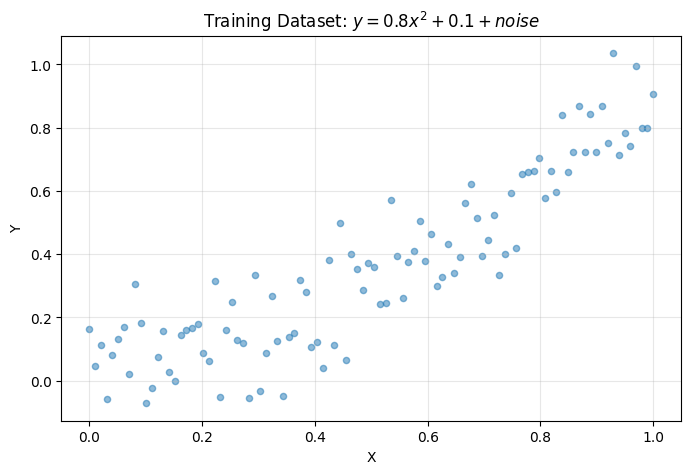

Dataset created: 100 samples


In [38]:
# Create dataset
X = jnp.linspace(0, 1, 100)[:, None]
Y = 0.8 * X ** 2 + 0.1 + brainstate.random.normal(0, 0.1, size=X.shape)


def dataset(batch_size):
    """Generate random batches from the dataset."""
    while True:
        idx = brainstate.random.choice(len(X), size=batch_size)
        yield X[idx], Y[idx]


# Visualize dataset
plt.figure(figsize=(8, 5))
plt.scatter(X, Y, alpha=0.5, s=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training Dataset: $y = 0.8x^2 + 0.1 + noise$')
plt.grid(alpha=0.3)
plt.show()

print(f"Dataset created: {len(X)} samples")

### Defining Training and Test Steps

Now we'll define JIT-compiled training and test functions using JAX transformations:

In [39]:
@jax.jit
def train_step(params, counts, batch):
    """Single training step with gradient descent."""
    x, y = batch

    def loss_fn(params):
        # Merge graph and compute loss
        model = brainstate.graph.treefy_merge(graphdef, params, counts)
        y_pred = model(x)
        new_counts = brainstate.graph.treefy_states(model, Count)
        loss = jnp.mean((y - y_pred) ** 2)
        return loss, new_counts

    # Compute gradients
    grad, counts = jax.grad(loss_fn, has_aux=True)(params)
    
    # Update parameters (simple SGD)
    params = jax.tree.map(lambda w, g: w - 0.1 * g, params, grad)

    return params, counts


@jax.jit
def test_step(params, counts, batch):
    """Evaluate model on test batch."""
    x, y = batch
    model = brainstate.graph.treefy_merge(graphdef, params, counts)
    y_pred = model(x)
    loss = jnp.mean((y - y_pred) ** 2)
    return {'loss': loss}


print("Training and test functions defined and JIT-compiled")

Training and test functions defined and JIT-compiled


### Training the Model

In [40]:
# Train the model
total_steps = 10_000
print(f"Training for {total_steps} steps...\n")

for step, batch in enumerate(dataset(32)):
    params_, counts_ = train_step(params_, counts_, batch)

    if step % 1000 == 0:
        logs = test_step(params_, counts_, (X, Y))
        print(f"Step {step:5d}: loss = {logs['loss']:.6f}")

    if step >= total_steps - 1:
        break

print("\nTraining complete!")

Training for 10000 steps...

Step     0: loss = 0.168351
Step  1000: loss = 0.011733
Step  2000: loss = 0.011768
Step  3000: loss = 0.011872
Step  4000: loss = 0.011736
Step  5000: loss = 0.011749
Step  6000: loss = 0.011963
Step  7000: loss = 0.011719
Step  8000: loss = 0.011735
Step  9000: loss = 0.011739

Training complete!


### Verifying the Trained Model

Let's restore the model and check how many times it was called:

Model called 10000 times during training
Expected: 10000 times



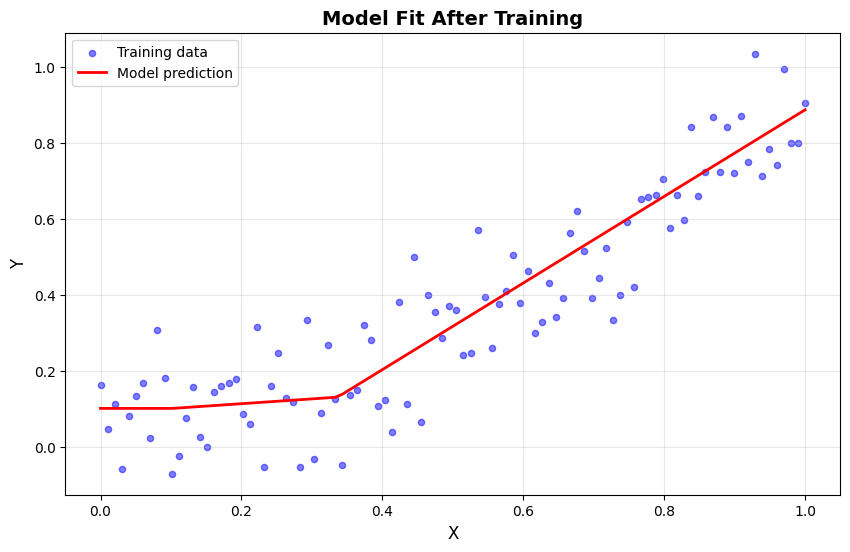

Final MSE loss: 0.011899


In [41]:
# Restore the trained model
model = brainstate.graph.treefy_merge(graphdef, params_, counts_)

print(f"Model called {model.count.value} times during training")
print(f"Expected: {total_steps} times\n")

# Make predictions
y_pred = model(X)

# Visualize results
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, alpha=0.5, s=20, label='Training data', color='blue')
plt.plot(X, y_pred, color='red', linewidth=2, label='Model prediction')
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('Model Fit After Training', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Compute final test loss
final_loss = jnp.mean((Y - y_pred) ** 2)
print(f"Final MSE loss: {final_loss:.6f}")

## Advanced Graph Patterns

Now let's explore some advanced architectural patterns using the graph system.

### Skip Connections (ResNet-style)

In [42]:
class ResidualBlock(brainstate.graph.Node):
    """Residual block with skip connection."""
    
    def __init__(self, dim):
        super().__init__()
        self.linear1 = brainstate.nn.Linear(dim, dim)
        self.linear2 = brainstate.nn.Linear(dim, dim)
    
    def __call__(self, x):
        # Main path
        residual = x
        x = jax.nn.relu(self.linear1(x))
        x = self.linear2(x)
        
        # Skip connection
        return jax.nn.relu(x + residual)


class ResNet(brainstate.graph.Node):
    """Simple ResNet with multiple residual blocks."""
    
    def __init__(self, dim, n_blocks):
        super().__init__()
        self.blocks = [ResidualBlock(dim) for _ in range(n_blocks)]
        # Register blocks as attributes
        for i, block in enumerate(self.blocks):
            setattr(self, f'block_{i}', block)
    
    def __call__(self, x):
        for block in self.blocks:
            x = block(x)
        return x


# Test ResNet
resnet = ResNet(dim=10, n_blocks=3)
x = brainstate.random.randn(5, 10)
output = resnet(x)

print(f"ResNet Architecture:")
print(f"  Input shape: {x.shape}")
print(f"  Output shape: {output.shape}")
print(f"  Number of blocks: {len(resnet.blocks)}")

# Count parameters
params = brainstate.graph.states(resnet, brainstate.ParamState)
total_params = sum(jnp.size(p.value) for p in params.values() if hasattr(p.value, 'shape'))
print(f"  Total parameters: {total_params:,}")

ResNet Architecture:
  Input shape: (5, 10)
  Output shape: (5, 10)
  Number of blocks: 3
  Total parameters: 0


### Multi-Path Networks (Inception-style)

In [43]:
class InceptionBlock(brainstate.graph.Node):
    """Inception-style block with multiple parallel paths."""
    
    def __init__(self, in_dim, out_dim):
        super().__init__()
        # Path 1: 1x1 (direct projection)
        self.path1 = brainstate.nn.Linear(in_dim, out_dim // 4)
        
        # Path 2: 1x1 -> 3x3 (simulated with linear)
        self.path2_a = brainstate.nn.Linear(in_dim, out_dim // 4)
        self.path2_b = brainstate.nn.Linear(out_dim // 4, out_dim // 4)
        
        # Path 3: 1x1 -> 5x5 (simulated)
        self.path3_a = brainstate.nn.Linear(in_dim, out_dim // 4)
        self.path3_b = brainstate.nn.Linear(out_dim // 4, out_dim // 4)
        
        # Path 4: pool -> 1x1
        self.path4 = brainstate.nn.Linear(in_dim, out_dim // 4)
    
    def __call__(self, x):
        # Execute all paths in parallel
        out1 = jax.nn.relu(self.path1(x))
        
        out2 = jax.nn.relu(self.path2_a(x))
        out2 = jax.nn.relu(self.path2_b(out2))
        
        out3 = jax.nn.relu(self.path3_a(x))
        out3 = jax.nn.relu(self.path3_b(out3))
        
        out4 = jax.nn.relu(self.path4(x))
        
        # Concatenate outputs
        return jnp.concatenate([out1, out2, out3, out4], axis=-1)


# Test Inception block
inception = InceptionBlock(in_dim=16, out_dim=32)
x = brainstate.random.randn(4, 16)
output = inception(x)

print(f"Inception Block:")
print(f"  Input shape: {x.shape}")
print(f"  Output shape: {output.shape}")
print(f"  4 parallel paths with concatenated outputs")

# Count parameters
params = brainstate.graph.states(inception, brainstate.ParamState)
total_params = sum(jnp.size(p.value) for p in params.values() if hasattr(p.value, 'shape'))
print(f"  Total parameters: {total_params:,}")

Inception Block:
  Input shape: (4, 16)
  Output shape: (4, 32)
  4 parallel paths with concatenated outputs
  Total parameters: 0


## Graph Analysis and Statistics

Let's create a utility function to analyze graph structures:

In [44]:
def analyze_graph(node):
    """Analyze computation graph statistics."""
    stats = {
        'total_nodes': 0,
        'total_params': 0,
        'param_tensors': 0,
        'node_types': {},
        'depth': 0
    }
    
    def traverse(n, depth=0):
        stats['total_nodes'] += 1
        stats['depth'] = max(stats['depth'], depth)
        
        # Count node type
        node_type = n.__class__.__name__
        stats['node_types'][node_type] = stats['node_types'].get(node_type, 0) + 1
        
        # Count parameters
        params = brainstate.graph.states(n, brainstate.ParamState)
        stats['param_tensors'] += len(params)
        for p in params.values():
            if hasattr(p.value, 'shape'):
                stats['total_params'] += jnp.size(p.value)
        
        # Traverse children
        for _, child in brainstate.graph.iter_node(n):
            if child is not n:
                traverse(child, depth + 1)
    
    traverse(node)
    return stats


# Analyze different models
models = {
    'MLP': MLP(),
    'ResNet': ResNet(dim=10, n_blocks=3),
    'Inception': InceptionBlock(in_dim=16, out_dim=32)
}

print("Graph Analysis Comparison:")
print("=" * 80)
print(f"{'Model':<15} {'Nodes':<8} {'Depth':<8} {'Param Tensors':<15} {'Total Params':<15}")
print("-" * 80)

for name, model in models.items():
    stats = analyze_graph(model)
    print(f"{name:<15} {stats['total_nodes']:<8} {stats['depth']:<8} "
          f"{stats['param_tensors']:<15} {stats['total_params']:<15,}")

print("\n" + "=" * 80)

Graph Analysis Comparison:
Model           Nodes    Depth    Param Tensors   Total Params   
--------------------------------------------------------------------------------
MLP             4        1        6               0              
ResNet          16       2        24              0              
Inception       7        1        12              0              



## Summary

`PyGraph` is a data structure specifically designed in the `brainstate` library to provide JAX function transformation support for complex graph structures. Its core value lies in:

### 1. Flexible Expression of Graph Structures
- Compared to traditional tree structures (pytree), graph structures can represent more complex node relationships and dependencies
- Supports cyclic references, making it suitable for expressing complex model structures like RNNs
- Nodes can contain arbitrary pytree array data or subgraph structures

### 2. Seamless Integration with the JAX Ecosystem
- Supports JAX's core functionalities, including automatic differentiation, vectorization, and parallelization
- Provides a mechanism for converting between graph structures and pytree via `treefy_split` and `treefy_merge`
- Natively supports JAX function transformations such as `jit`, `vmap`, and `grad`

### 3. Rich API for Graph Operations
- **Structure operations**: `graphdef`, `iter_node`, `iter_leaf`, `nodes`, `states`
- **Transformations**: `treefy_states`, `clone`, `treefy_split`, `treefy_merge`, `flatten`, `unflatten`
- **Modifications**: `pop_states`, `update_states`
- **Conversions**: `graph_to_tree`, `tree_to_graph`

### 4. Powerful Filter System
- Filter by type: `brainstate.ParamState`, `brainstate.ShortTermState`, etc.
- Combine filters: Use tuples/lists for "any" logic
- Match everything: `...` or `True`
- Match nothing: `None` or `False`

### 5. Structure preserving state management
- Separate graph structure (`graphdef`) from state values (`treefy_states`)
- Retrieve states according to state filters
